# Vision

My intention with this final project is to create a bot to take in stories, such as the ever popular tragedy of Darth Plagueis the Wise and have it return its own story as such. I was inspired by an older attempt at something similar except based on the Harry Potter books. As a result, I hope to achieve an output that is at least somewhat amusing, if only from the perspective of the culture surrounding Star Wars Prequel memes. I had a difficult time finding data sets of various sith legends, so have instead decided to take quotes from the Hitchhiker’s Guide to the Galaxy series for use instead.

# Background

I will be using Word2Vec in order to find relationships between various words. I will also be using Word2Vec in order to find word similarities, such as dirty versus filthy. I will primarily be taking sources for use of Word2Vec in these ways from these sources: https://medium.freecodecamp.org/how-to-get-started-with-word2vec-and-then-how-to-make-it-work-d0a2fca9dad3, https://www.geeksforgeeks.org/python-word-embedding-using-word2vec/, https://adventuresinmachinelearning.com/word2vec-tutorial-tensorflow/


I will be comparing the relationships and similarities found by Word2Vec with a Keras LSTM model to achieve something at least somewhat like an actual sentence. I also looked at the output presented by n-gram models to see the difference in N-gram sentences versus those created by Keras. (implimentation taken from Maxim)

# Implimentation

In [2]:
import numpy as np
import gensim
import logging
import string
import ssl
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

ssl._create_default_https_context = ssl._create_unverified_context

from keras.callbacks import LambdaCallback
from keras.layers.recurrent import LSTM

from keras.layers.embeddings import Embedding
from keras.layers import Dense, Activation
from keras.models import Sequential
from keras.utils.data_utils import get_file

url = 'https://github.com/jobaird/cs344/blob/master/AI%20Project/Hitchhikers_quotes.txt'
path = get_file('hitch.txt', origin=url)

def word2idx(word):
  return word_model.wv.vocab[word].index

def idx2word(idx):
  return word_model.wv.index2word[idx]

# tsne implimentation from:
# https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)

    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

# code taken from
# https://gist.github.com/maxim5/c35ef2238ae708ccb0e55624e9e0252b
# for purpose of creating text generation
#edits done to values in attempts to get better output.
def sample(preds, temperature=1.0):
  if temperature <= 0:
    return np.argmax(preds)
  preds = np.asarray(preds).astype('float64')
  preds = np.log(preds) / temperature
  exp_preds = np.exp(preds)
  preds = exp_preds / np.sum(exp_preds)
  probas = np.random.multinomial(1, preds, 1)
  return np.argmax(probas)


def generate_next(text, num_generated=20):
  word_idxs = [word2idx(word) for word in text.lower().split()]
  for i in range(num_generated):
    prediction = model.predict(x=np.array(word_idxs))
    idx = sample(prediction[-1], temperature=0.7)
    word_idxs.append(idx)
  return ' '.join(idx2word(idx) for idx in word_idxs)

def on_epoch_end(epoch, _):
  print('\nGenerating text after epoch: %d' % epoch)
  texts = [
      'the universe',
      'the guide',
      'arthur dent',
      'zaphod',
      'the answer',
  ]
  for text in texts:
    sample = generate_next(text)
    print('%s... -> %s' % (text, sample))

First, I trained the Word2Vec model, and checked it for similarities for certain words, which I would go on to use as the starting points for my sentences(Kavita Ganesen). I also created a tsne model to display some similarity found by the word2vec model. (Kaggle)

In [4]:
max_sentence_len = 40
with open(path) as file_:
  docs = file_.readlines()
sentences = [[word for word in doc.lower().translate(string.punctuation).split()[:max_sentence_len]] for doc in docs]
print('\nTraining word2vec...')
word_model = gensim.models.Word2Vec(sentences, size=40, min_count=1, window=5, iter=200)
pretrained_weights = word_model.wv.syn0
vocab_size, emdedding_size = pretrained_weights.shape
print('Result embedding shape:', pretrained_weights.shape)
print('Checking similar words:')
for word in ['universe', 'guide', 'arthur', 'zaphod', 'answer']:
  most_similar = ', '.join('%s (%.2f)' % (similar, dist) for similar, dist in word_model.most_similar(word)[:8])
  print('  %s -> %s' % (word, most_similar))


Training word2vec...
Result embedding shape: (2856, 40)
Checking similar words:
  universe -> as, (0.77), beginning (0.76), everything"+ (0.76), such (0.75), ways (0.74), life, (0.74), far: (0.73), concerning (0.73)
  guide -> hitchhiker's (0.96), galaxy (0.85), indeed. (0.85), fish," (0.83), quietly, (0.83), definitive. (0.82), require (0.81), supplanted (0.78)
  arthur -> cheered (0.87), terrific," (0.84), "oh!" (0.82), up. (0.82), sinking (0.81), "pity," (0.80), himself, (0.79), low (0.78)
  zaphod -> experienced (0.81), relationship (0.79), "yeah," (0.79), patting (0.77), prospect (0.74), tried (0.73), horror (0.72), arrived (0.71)
  answer -> mutually (0.90), question (0.89), “that (0.88), question, (0.86), life, (0.84), ultimate (0.83), exclusive. (0.83), is."+ (0.82)


/Users/John/PycharmProjects/cs344/venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  import sys
/Users/John/PycharmProjects/cs344/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if sys.path[0] == '':


/Users/John/PycharmProjects/cs344/venv/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


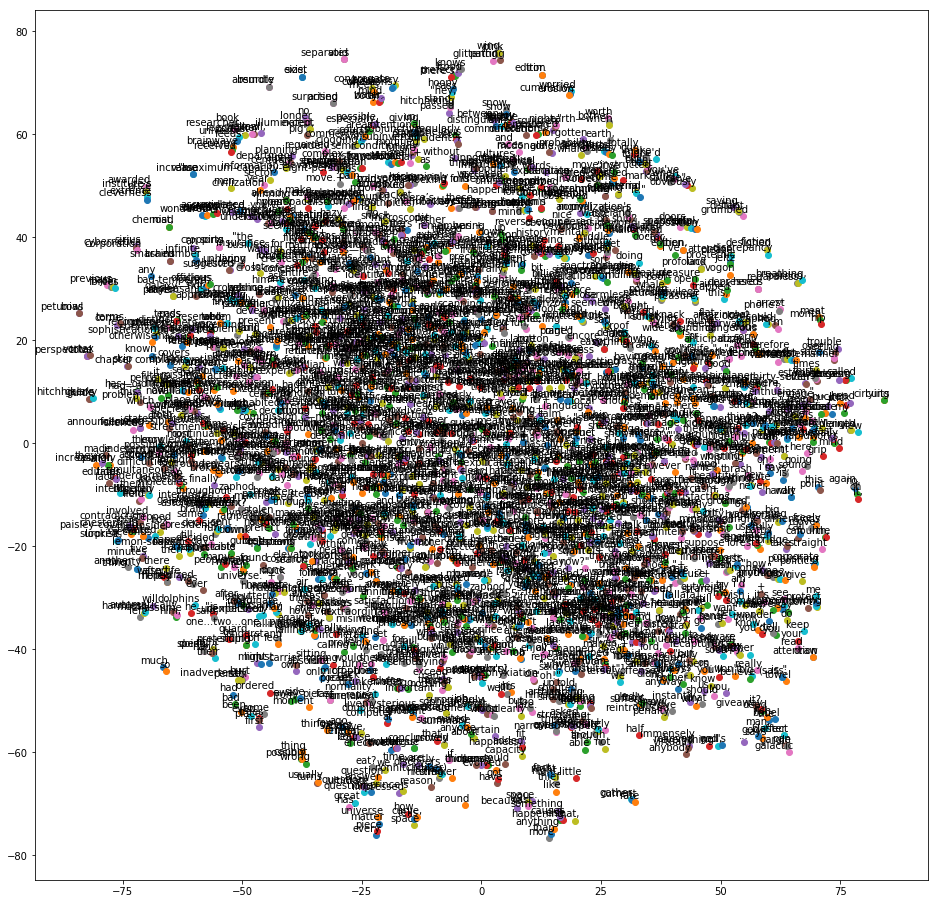

In [5]:
tsne_plot(word_model)

The interesting thing about the similarities found by the word2vec model comes mostly from the similarities in relevance to names. While the word similarities are taken from words that are often associated with the original word (e.g. guide and hitchhiker's), the word similarities found for names seem to be in more relation to the characters personalities. Arthur is "low" and "sinking" but also has moments of happiness, and sometimes literal flight, shown in "up", "cheered", and "terrific". Zaphod meanwhile is "experienced" but also has a "relationship" and "tried" to accomplish his goals, its also a bit more all over the place than Arthur, but that fits the character pretty well to the books.

After training the word2vec model, I then ran the output of that through an lstm model, and then trained the model, and had it create some sentences after every generation. Interestingly, I found that 50 generations of the text generation was the most effective, as at that point the loss stopped decreasing by much at all, and the text didn't really get more interesting, maybe even getting worse at around 75 generations or so.

In [6]:
print('\nPreparing the data for LSTM...')
train_x = np.zeros([len(sentences), max_sentence_len], dtype=np.int32)
train_y = np.zeros([len(sentences)], dtype=np.int32)
for i, sentence in enumerate(sentences):
  for t, word in enumerate(sentence[:-1]):
    train_x[i, t] = word2idx(word)
  train_y[i] = word2idx(sentence[-1])
print('train_x shape:', train_x.shape)
print('train_y shape:', train_y.shape)


print('\nTraining LSTM...')
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=emdedding_size, weights=[pretrained_weights]))
model.add(LSTM(units=emdedding_size))
model.add(Dense(units=vocab_size))
model.add(Activation('softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')



Preparing the data for LSTM...
train_x shape: (371, 40)
train_y shape: (371,)

Training LSTM...


In [ ]:
model.fit(train_x, train_y,
          batch_size=256,
          epochs=50,
          callbacks=[LambdaCallback(on_epoch_end=on_epoch_end)])

the universe... -> the universe serious narrowness engage nonabsolute glittering covers heart calm.+ either thinker, announcement, i?+ again, something, exciting, watered is?"+ "fiscal crossing.+ thing..."

the guide... -> the guide summarise: has—or beta, hope recall prak, of me?+ unhip change.+ meeting."+ job. passed water. deficiency centigrade unimaginable sigh protested massive

arthur dent... -> arthur dent does.”+ something, one...two...one...probability guards hold part spend bricks done."+ distinct to one. snapped concerning choice, .+ tipped massive extend it!”+

zaphod... -> zaphod arthur.+ suits unhappy corporation hardest "simple. bizarrely upper stupid wind?+ cleverness was," is:+ murmuring ..."and observed together. visiting already "my

the answer... -> the answer shrewd tristesse regarded we least copied.+ daughter."+ movies."+ waking hoped dominant current bridge bothered transport, continued consultant"] alpha snapped me,"

I noticed that general grammer makes more or less sense from the output, but the actual meaning tends to be complete and utter nonsense. I think that the grammar could probably have been improved with a better/larger set of data than just 371 lines of qoutes, but it's possible that the grammar could have been weird anyway.

If there was anything that I would do with this implimentation in the future it would be to feed it the whole text of all the books and see if that gave any really good improvements in the output of the code.

# Implications

In terms of the possible implications of this technology, there could be many different applications and or consequences. One of the greatest applications of this sort of technology could perhaps be in AI sentence construction similar to Cortana, Alexa, or Siri. With proper word association and generation, these system could get to a point where they could dynamically generate sentences, and thus seem closer to human than they would with pre-defined responses.

Another possible application of this would be to allow for these same programs to better build associations of what the human on the other end was saying. This would allow these “companion” AIs to become more personalized to their users, and thus make them much more usable than they may otherwise be.

One problem that could, albeit unlikely, potentially arise would be for AI to become capable of generating it’s own artistic content such as plays, movies, or books. Some people would be scared of the AI replacing humanity, or the fact that people could become complacent and subject themselves to even more mass-produced awful art forms than critics already think they do. I do not believe this is a realistic concern however, as AI would need something a bit more than simple word associations in order to create real art of this kind.

This project helped me realize that even if AI get's to the point where it can create anything with any real meaning, it will likely still need to be sanity checked by an actual person in order for it to really work as a piece of literature.

# Bibliography

Ganesan, Kavita, and Kavita Ganesan. “How to Get Started with Word2Vec - and Then How to Make It Work.” FreeCodeCamp.org, FreeCodeCamp.org, 19 Feb. 2018, medium.freecodecamp.org/how-to-get-started-with-word2vec-and-then-how-to-make-it-work-d0a2fca9dad3.
Maxim. “Text Generator Based on LSTM Model with Pre-Trained Word2Vec Embeddings in Keras.” Gist, gist.github.com/maxim5/c35ef2238ae708ccb0e55624e9e0252b.
“Visualizing Word Vectors with t-SNE.” Kaggle, www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne.